In [1]:
import collections as coll
import math
import pickle
import string
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style
from nltk.corpus import cmudict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import nltk

nltk.download('cmudict')
nltk.download('stopwords')

style.use("ggplot")
cmuDictionary = None

[nltk_data] Downloading package cmudict to
[nltk_data]     /Users/haileywu/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/haileywu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import Data

In [2]:
jane1 = pd.read_csv("../../Dataset_v2/cleaned/Jane/Pride_and_Prejudice_Jane_Austen.csv")
jane2 = pd.read_csv("../../Dataset_v2/cleaned/Jane/Emma_Jane_Austen.csv")

Fitzgerald1 = pd.read_csv("../../Dataset_v2/cleaned/Fitzgerald/The_Great_Gatsby.csv")
Fitzgerald2 = pd.read_csv("../../Dataset_v2/cleaned/Fitzgerald/TheBeautifulAndDamned.csv")

Mark1 = pd.read_csv("../../Dataset_v2/cleaned/Mark/TheAdventuresOfTomSawyer.csv")
Mark2 = pd.read_csv("../../Dataset_v2/cleaned/Mark/ThePrinceAndThePauper.csv")

Charles1 = pd.read_csv("../../Dataset_v2/cleaned/CharlesDickens/ATaleOfTwoCities.csv")
Charles2 = pd.read_csv("../../Dataset_v2/cleaned/CharlesDickens/BarnabyRudge.csv")

## Functions

ref: https://github.com/Hassaan-Elahi/Writing-Styles-Classification-Using-Stylometric-Analysis/blob/master/Code/main.py

In [3]:
def Avg_wordLength(str):
    str.translate(string.punctuation)
    tokens = word_tokenize(str, language='english')
    st = [",", ".", "'", "!", '"', "#", "$", "%", "&", "(", ")", "*", "+", "-", ".", "/", ":", ";", "<", "=", '>', "?",
          "@", "[", "\\", "]", "^", "_", '`', "{", "|", "}", '~', '\t', '\n']
    stop = stopwords.words('english') + st
    words = [word for word in tokens if word not in stop]
    return np.average([len(word) for word in words])

In [4]:
def Avg_SentLenghtByCh(text):
    tokens = sent_tokenize(text)
    return np.average([len(token) for token in tokens])

In [5]:
def Avg_SentLenghtByWord(text):
    tokens = sent_tokenize(text)
    return np.average([len(token.split()) for token in tokens])

In [6]:
def syllable_count_Manual(word):
    word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
            if word.endswith("e"):
                count -= 1
    if count == 0:
        count += 1
    return count


In [7]:
def syllable_count(word):
    global cmuDictionary
    d = cmuDictionary
    try:
        syl = [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]][0]
    except:
        syl = syllable_count_Manual(word)
    return syl

In [8]:
def Avg_Syllable_per_Word(text):
    tokens = word_tokenize(text, language='english')
    st = [",", ".", "'", "!", '"', "#", "$", "%", "&", "(", ")", "*", "+", "-", ".", "/", ":", ";", "<", "=", '>', "?",
          "@", "[", "\\", "]", "^", "_", '`', "{", "|", "}", '~', '\t', '\n']
    stop = stopwords.words('english') + st
    words = [word for word in tokens if word not in stop]
    syllabls = [syllable_count(word) for word in words]
    p = (" ".join(words))
    return sum(syllabls) / max(1, len(words))

In [9]:
def CountSpecialCharacter(text):
    st = ["#", "$", "%", "&", "(", ")", "*", "+", "-", "/", "<", "=", '>',
          "@", "[", "\\", "]", "^", "_", '`', "{", "|", "}", '~', '\t', '\n']
    count = 0
    for i in text:
        if (i in st):
            count = count + 1
    return count / len(text)

In [10]:
def CountPuncuation(text):
    st = [",", ".", "'", "!", '"', ";", "?", ":", ";"]
    count = 0
    for i in text:
        if (i in st):
            count = count + 1
    return float(count) / float(len(text))


In [11]:
def CountFunctionalWords(text):
    functional_words = """a between in nor some upon
    about both including nothing somebody us
    above but inside of someone used
    after by into off something via
    all can is on such we
    although cos it once than what
    am do its one that whatever
    among down latter onto the when
    an each less opposite their where
    and either like or them whether
    another enough little our these which
    any every lots outside they while
    anybody everybody many over this who
    anyone everyone me own those whoever
    anything everything more past though whom
    are few most per through whose
    around following much plenty till will
    as for must plus to with
    at from my regarding toward within
    be have near same towards without
    because he need several under worth
    before her neither she unless would
    behind him no should unlike yes
    below i nobody since until you
    beside if none so up your
    """

    functional_words = functional_words.split()
    words = RemoveSpecialCHs(text)
    count = 0

    for i in text:
        if i in functional_words:
            count += 1

    return count / len(words)


In [12]:
def RemoveSpecialCHs(text):
    text = word_tokenize(text)
    st = [",", ".", "'", "!", '"', "#", "$", "%", "&", "(", ")", "*", "+", "-", ".", "/", ":", ";", "<", "=", '>', "?",
          "@", "[", "\\", "]", "^", "_", '`', "{", "|", "}", '~', '\t', '\n']

    words = [word for word in text if word not in st]
    return words

In [13]:
def hapaxLegemena(text):
    words = RemoveSpecialCHs(text)
    V1 = 0
    # dictionary comprehension . har word kay against value 0 kardi
    freqs = {key: 0 for key in words}
    for word in words:
        freqs[word] += 1
    for word in freqs:
        if freqs[word] == 1:
            V1 += 1
    N = len(words)
    V = float(len(set(words)))
    R = 100 * math.log(N) / max(1, (1 - (V1 / V)))
    h = V1 / N
    return R, h

In [14]:
def hapaxDisLegemena(text):
    words = RemoveSpecialCHs(text)
    count = 0
    # Collections as coll Counter takes an iterable collapse duplicate and counts as
    # a dictionary how many equivelant items has been entered
    freqs = coll.Counter()
    freqs.update(words)
    for word in freqs:
        if freqs[word] == 2:
            count += 1

    h = count / float(len(words))
    S = count / float(len(set(words)))
    return S, h

In [15]:
def AvgWordFrequencyClass(text):
    words = RemoveSpecialCHs(text)
    # dictionary comprehension . har word kay against value 0 kardi
    freqs = {key: 0 for key in words}
    for word in words:
        freqs[word] += 1
    maximum = float(max(list(freqs.values())))
    return np.average([math.floor(math.log((maximum + 1) / (freqs[word]) + 1, 2)) for word in words])

In [16]:
def typeTokenRatio(text):
    words = word_tokenize(text)
    return len(set(words)) / len(words)

In [17]:
def BrunetsMeasureW(text):
    words = RemoveSpecialCHs(text)
    a = 0.17
    V = float(len(set(words)))
    N = len(words)
    B = (V - a) / (math.log(N))
    return B


In [18]:
def YulesCharacteristicK(text):
    words = RemoveSpecialCHs(text)
    N = len(words)
    freqs = coll.Counter()
    freqs.update(words)
    vi = coll.Counter()
    vi.update(freqs.values())
    M = sum([(value * value) * vi[value] for key, value in freqs.items()])
    K = 10000 * (M - N) / math.pow(N, 2)
    return K


In [19]:
def ShannonEntropy(text):
    words = RemoveSpecialCHs(text)
    lenght = len(words)
    freqs = coll.Counter()
    freqs.update(words)
    arr = np.array(list(freqs.values()))
    distribution = 1. * arr
    distribution /= max(1, lenght)
    import scipy as sc
    H = sc.stats.entropy(distribution, base=2)
    # H = sum([(i/lenght)*math.log(i/lenght,math.e) for i in freqs.values()])
    return H

In [20]:
def SimpsonsIndex(text):
    words = RemoveSpecialCHs(text)
    freqs = coll.Counter()
    freqs.update(words)
    N = len(words)
    n = sum([1.0 * i * (i - 1) for i in freqs.values()])
    D = 1 - (n / (N * (N - 1)))
    return D

In [21]:
def FleschReadingEase(text, NoOfsentences):
    words = RemoveSpecialCHs(text)
    l = float(len(words))
    scount = 0
    for word in words:
        scount += syllable_count(word)

    I = 206.835 - 1.015 * (l / float(NoOfsentences)) - 84.6 * (scount / float(l))
    return I

In [22]:
def FleschCincadeGradeLevel(text, NoOfSentences):
    words = RemoveSpecialCHs(text)
    scount = 0
    for word in words:
        scount += syllable_count(word)

    l = len(words)
    F = 0.39 * (l / NoOfSentences) + 11.8 * (scount / float(l)) - 15.59
    return F

In [23]:
def dale_chall_readability_formula(text, NoOfSectences):
    words = RemoveSpecialCHs(text)
    difficult = 0
    adjusted = 0
    NoOfWords = len(words)
    with open('dale-chall.pkl', 'rb') as f:
        fimiliarWords = pickle.load(f)
    for word in words:
        if word not in fimiliarWords:
            difficult += 1
    percent = (difficult / NoOfWords) * 100
    if (percent > 5):
        adjusted = 3.6365
    D = 0.1579 * (percent) + 0.0496 * (NoOfWords / NoOfSectences) + adjusted
    return D

In [24]:
def GunningFoxIndex(text, NoOfSentences):
    words = RemoveSpecialCHs(text)
    NoOFWords = float(len(words))
    complexWords = 0
    for word in words:
        if (syllable_count(word) > 2):
            complexWords += 1

    G = 0.4 * ((NoOFWords / NoOfSentences) + 100 * (complexWords / NoOFWords))
    return G

## Feature Generation

In [25]:
def featuregeneration(df):
    # Lexical Features
    df['Avg_wordLength'] = df.apply(lambda row : Avg_wordLength(row.Text), axis = 1)
    df['Avg_SentLenghtByCh'] = df.apply(lambda row : Avg_SentLenghtByCh(row.Text), axis = 1)
    df['Avg_SentLenghtByWord'] = df.apply(lambda row : Avg_SentLenghtByWord(row.Text), axis = 1)
    #df['syllable_count'] = df.apply(lambda row : syllable_count(row.Text), axis = 1)
    df['Avg_Syllable_per_Word'] = df.apply(lambda row : Avg_Syllable_per_Word(row.Text), axis = 1)
    df['CountSpecialCharacter'] = df.apply(lambda row : CountSpecialCharacter(row.Text), axis = 1)
    df['CountPuncuation'] = df.apply(lambda row : CountPuncuation(row.Text), axis = 1)
    df['CountFunctionalWords'] = df.apply(lambda row : CountFunctionalWords(row.Text), axis = 1)
    
    
    # vocabulary richness features 
    df['HonoreMeasureR'] = df.apply(lambda row : hapaxLegemena(row.Text)[0], axis = 1)
    df['hapax'] = df.apply(lambda row : hapaxLegemena(row.Text)[1], axis = 1)
    df['SichelesMeasureS'] = df.apply(lambda row : hapaxDisLegemena(row.Text)[0], axis = 1)
    df['dihapax'] = df.apply(lambda row : hapaxDisLegemena(row.Text)[1], axis = 1)
    #df['AvgWordFrequencyClass'] = df.apply(lambda row : AvgWordFrequencyClass(row.Text), axis = 1)
    #df['typeTokenRatio'] = df.apply(lambda row : typeTokenRatio(row.Text), axis = 1)
    df['BrunetsMeasureW'] = df.apply(lambda row : BrunetsMeasureW(row.Text), axis = 1)
    df['YulesCharacteristicK'] = df.apply(lambda row : YulesCharacteristicK(row.Text), axis = 1)
    df['ShannonEntropy'] = df.apply(lambda row : ShannonEntropy(row.Text), axis = 1)
    df['SimpsonsIndex'] = df.apply(lambda row : SimpsonsIndex(row.Text), axis = 1)

    # readability features 
    df['num_sentence'] = df.apply(lambda row : len(sent_tokenize(row.Text)), axis = 1)
    df['FleschReadingEase'] = df.apply(lambda row : FleschReadingEase(row.Text,row.num_sentence), axis = 1)
    df['FleschCincadeGradeLevel'] = df.apply(lambda row : FleschCincadeGradeLevel(row.Text,row.num_sentence), axis = 1)
    df['dale_chall_readability_formula'] = df.apply(lambda row : dale_chall_readability_formula(row.Text,row.num_sentence), axis = 1)
    df['GunningFoxIndex'] = df.apply(lambda row : GunningFoxIndex(row.Text,row.num_sentence), axis = 1)
    

## EDA

In [27]:
jane1 = jane1[['ChapterNum','Text']]
jane1f = jane1.groupby('ChapterNum').agg({'Text': ' '.join})

jane2 = jane2[['ChapterNum','Text']]
jane2f = jane2.groupby('ChapterNum').agg({'Text': ' '.join})

Fitzgerald1 = Fitzgerald1[['ChapterNum','Text']]
#i = Fitzgerald1[(Fitzgerald1.ChapterNum == 0)].index
#Fitzgerald1 = Fitzgerald1.drop(i)
Fitzgerald1f = Fitzgerald1.groupby('ChapterNum').agg({'Text': ' '.join})

Fitzgerald2 = Fitzgerald2[['ChapterNum','Text']]
Fitzgerald2f = Fitzgerald2.groupby('ChapterNum').agg({'Text': ' '.join})

Mark1 = Mark1[['ChapterNum','Text']]
Mark1f = Mark1.groupby('ChapterNum').agg({'Text': ' '.join})

Mark2 = Mark2[['ChapterNum','Text']]
Mark2f = Mark2.groupby('ChapterNum').agg({'Text': ' '.join})

Charles1 = Charles1[['ChapterNum','Text']]
Charles1f = Charles1.groupby('ChapterNum').agg({'Text': ' '.join})

Charles2 = Charles2[['ChapterNum','Text']]
Charles2f = Charles2.groupby('ChapterNum').agg({'Text': ' '.join})

In [28]:
featuregeneration(jane1f)
featuregeneration(jane2f)

featuregeneration(Fitzgerald1f)
featuregeneration(Fitzgerald2f)

featuregeneration(Mark1f)
featuregeneration(Mark2f)


featuregeneration(Charles1f)
featuregeneration(Charles2f)

In [29]:
jane1f['Author']='Jane'
jane2f['Author']='Jane'
Fitzgerald1f['Author']='Fitzgerald'
Fitzgerald2f['Author']='Fitzgerald'
Mark1f['Author']='Mark'
Mark2f['Author']='Mark'
Charles1f['Author']='Charles'
Charles2f['Author']='Charles'

jane1f['Book']='Pride_and_Prejudice'
jane2f['Book']='Emma'
Fitzgerald1f['Book']='The_Great_Gatsby'
Fitzgerald2f['Book']='The_Beautiful_And_Damned'
Mark1f['Book']='The_Adventures_Of_Tom_Sawyer'
Mark2f['Book']='The_Prince_And_The_Pauper'
Charles1f['Book']='A_Tale_Of_Two_Cities'
Charles2f['Book']='Barnaby_Rudge'


jane1f['y']='1'
jane2f['y']='1'
Fitzgerald1f['y']='0'
Fitzgerald2f['y']='0'
Mark1f['y']='0'
Mark2f['y']='0'
Charles1f['y']='0'
Charles2f['y']='0'

In [30]:
jane1f.shape

(61, 24)

In [42]:
Fitzgerald2f.shape

(9, 24)

In [43]:
Fitzgerald1f.shape

(9, 24)

In [32]:
def PCAgraph(booksdf,aspect):
    if aspect == 'Lexical':
        vector = booksdf[["Avg_wordLength","Avg_SentLenghtByWord","Avg_SentLenghtByCh",
        "CountSpecialCharacter","Avg_Syllable_per_Word","CountFunctionalWords",
                          "CountPuncuation"]]
    elif aspect == 'Vocabulary':
        vector = booksdf[["hapax","dihapax","HonoreMeasureR","SichelesMeasureS",
        "BrunetsMeasureW","YulesCharacteristicK","ShannonEntropy","SimpsonsIndex"]]
    elif aspect == 'Readability':
        vector = booksdf[["FleschReadingEase","FleschCincadeGradeLevel","GunningFoxIndex",
                          "dale_chall_readability_formula", "ShannonEntropy","SimpsonsIndex"]]
    else:#all
        vector = booksdf[["Avg_wordLength","Avg_SentLenghtByWord","Avg_SentLenghtByCh",
        "CountSpecialCharacter","Avg_Syllable_per_Word","CountFunctionalWords",
        "CountPuncuation",
        "FleschReadingEase","FleschCincadeGradeLevel","GunningFoxIndex",
        "dale_chall_readability_formula", "ShannonEntropy","SimpsonsIndex",
        "hapax","dihapax","HonoreMeasureR","SichelesMeasureS",
        "BrunetsMeasureW","YulesCharacteristicK","ShannonEntropy","SimpsonsIndex"]]
    arr = (np.array(vector))

    # mean normalization of the data . converting into normal distribution having mean=0 , -0.1<x<0.1
    sc = StandardScaler()
    x = sc.fit_transform(arr)

    # Breaking into principle components
    pca = PCA(n_components=2)
    components = (pca.fit_transform(x))
    columnname1 = aspect+'_PCA_1'
    columnname2 = aspect+'_PCA_2'
    result= pd.DataFrame(data=components,columns= [columnname1,columnname2])
    return result


In [33]:
allbookf =pd.concat([jane1f,jane2f,Fitzgerald1f,Fitzgerald2f,
                     Mark1f,Mark2f,Charles1f,Charles2f])
resultLexical = PCAgraph(allbookf,'Lexical')
resultVocabulary = PCAgraph(allbookf,'Vocabulary')
resultReadability = PCAgraph(allbookf,'Readability')
resultAll = PCAgraph(allbookf,'All')

allbookf_pca = allbookf.join(resultLexical)
allbookf_pca = allbookf_pca.join(resultVocabulary)
allbookf_pca = allbookf_pca.join(resultReadability)
allbookf_pca = allbookf_pca.join(resultAll)

In [34]:
allbookf.shape

(330, 24)

In [35]:
allbookf_pca.shape

(330, 32)

In [36]:
allbookf_pca.isnull().sum()

Text                              0
Avg_wordLength                    0
Avg_SentLenghtByCh                0
Avg_SentLenghtByWord              0
Avg_Syllable_per_Word             0
CountSpecialCharacter             0
CountPuncuation                   0
CountFunctionalWords              0
HonoreMeasureR                    0
hapax                             0
SichelesMeasureS                  0
dihapax                           0
BrunetsMeasureW                   0
YulesCharacteristicK              0
ShannonEntropy                    0
SimpsonsIndex                     0
num_sentence                      0
FleschReadingEase                 0
FleschCincadeGradeLevel           0
dale_chall_readability_formula    0
GunningFoxIndex                   0
Author                            0
Book                              0
y                                 0
Lexical_PCA_1                     0
Lexical_PCA_2                     0
Vocabulary_PCA_1                  0
Vocabulary_PCA_2            

Text(0.5, 0.98, 'Lexical by Author and Book')

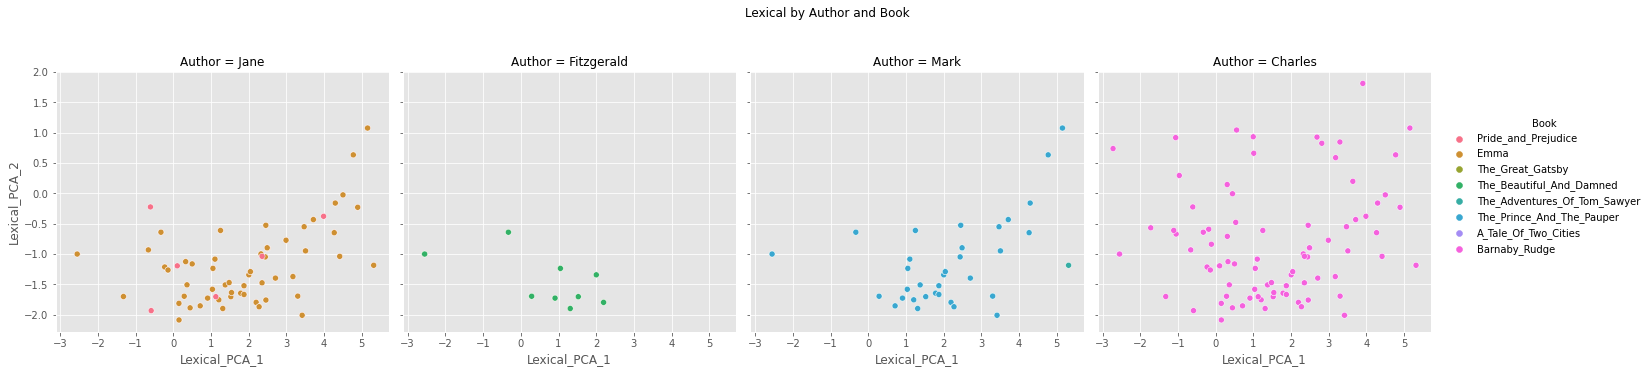

In [37]:
rp = sns.relplot(
    data=allbookf_pca, x="Lexical_PCA_1", y="Lexical_PCA_2",
    col="Author", hue="Book",
    kind="scatter"
)
rp.fig.subplots_adjust(top=0.8) # adjust the Figure in rp
rp.fig.suptitle('Lexical by Author and Book')

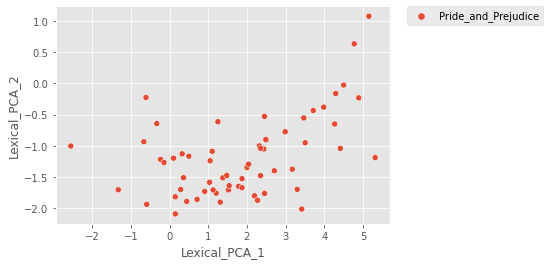

In [38]:
sns.scatterplot(data=allbookf_pca[allbookf_pca['Book']=='Pride_and_Prejudice'], x="Lexical_PCA_1", y="Lexical_PCA_2",hue="Book")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0.98, 'Vocabulary by Author and Book')

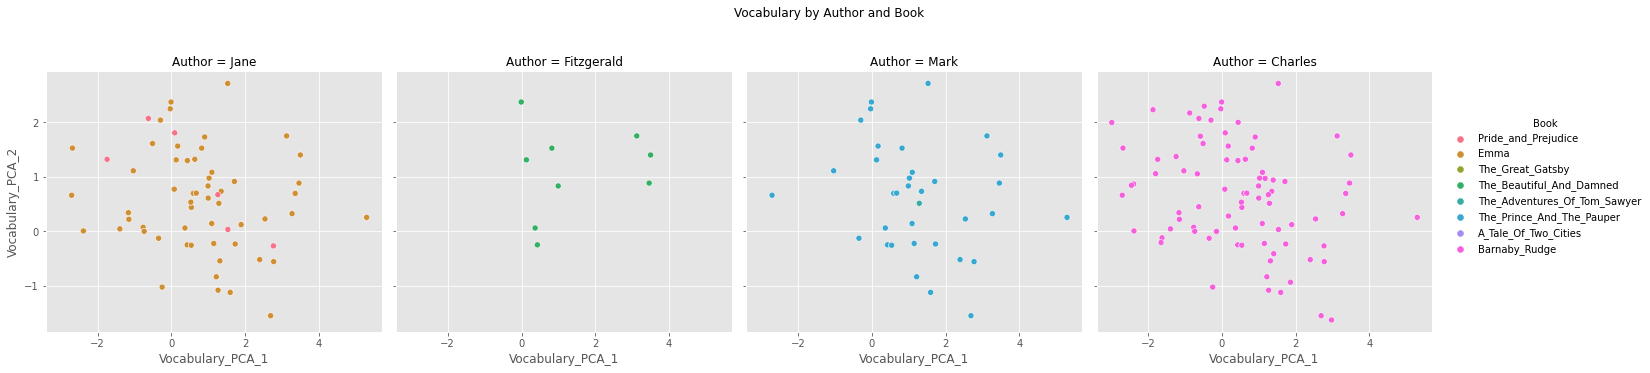

In [39]:
rp = sns.relplot(
    data=allbookf_pca, x="Vocabulary_PCA_1", y="Vocabulary_PCA_2",
    col="Author", hue="Book",
    kind="scatter"
)
rp.fig.subplots_adjust(top=0.8) # adjust the Figure in rp
rp.fig.suptitle('Vocabulary by Author and Book')

Text(0.5, 0.98, 'Readability by Author and Book')

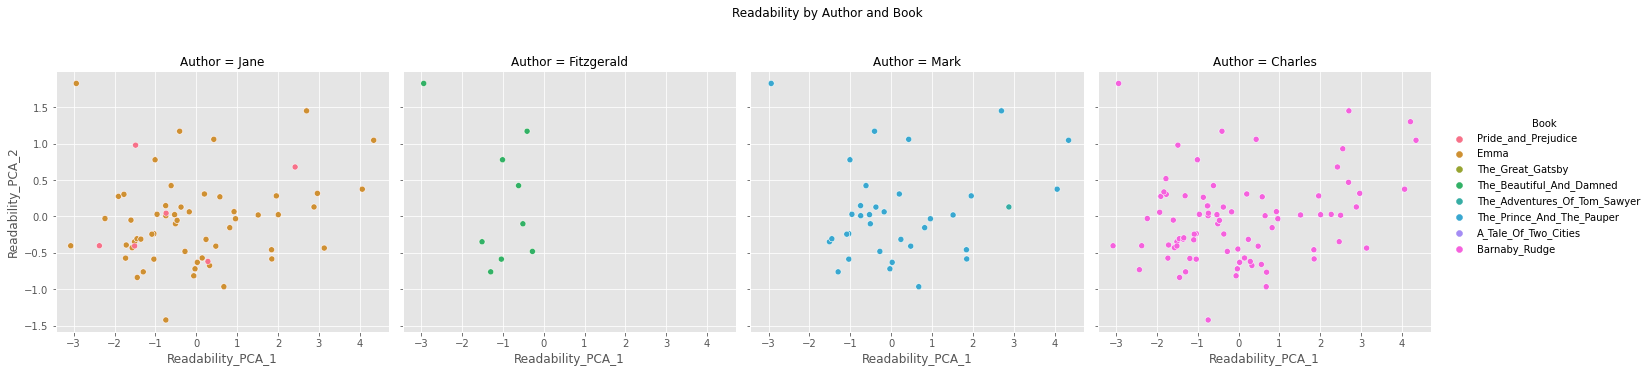

In [40]:
rp = sns.relplot(
    data=allbookf_pca, x="Readability_PCA_1", y="Readability_PCA_2",
    col="Author", hue="Book",
    kind="scatter"
)
rp.fig.subplots_adjust(top=0.8) # adjust the Figure in rp
rp.fig.suptitle('Readability by Author and Book')

Text(0.5, 0.98, 'All features to 2-PCA by Author and Book')

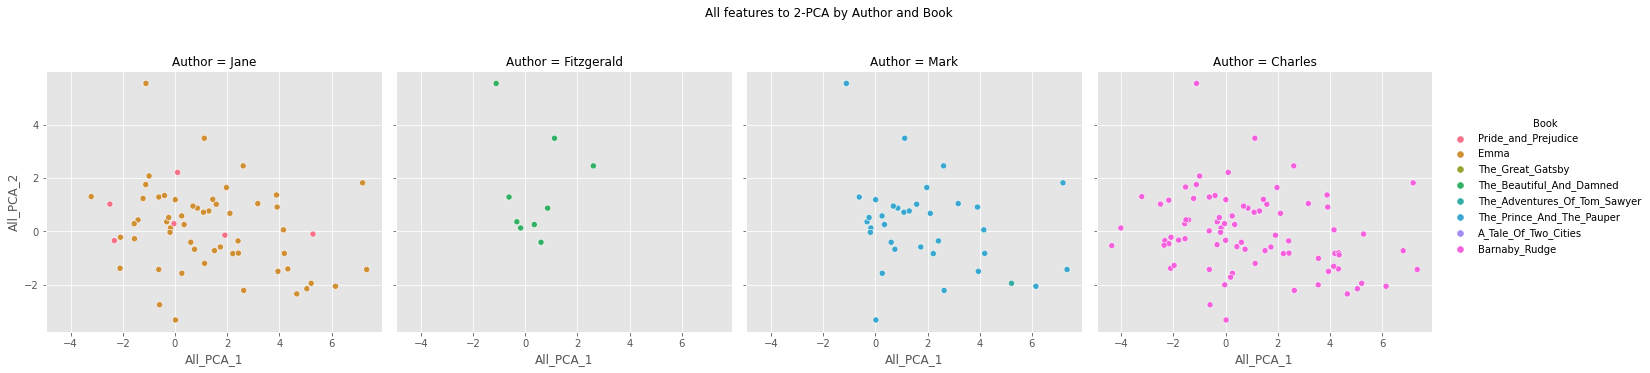

In [44]:
rp = sns.relplot(
    data=allbookf_pca, x="All_PCA_1", y="All_PCA_2",
    col="Author", hue="Book",
    kind="scatter"
)
rp.fig.subplots_adjust(top=0.8) # adjust the Figure in rp
rp.fig.suptitle('All features to 2-PCA by Author and Book')

## Other EDAs

In [85]:
Fitzgerald1f.describe()

,Avg_wordLength,Avg_SentLenghtByCh,Avg_SentLenghtByWord,Avg_Syllable_per_Word,CountSpecialCharacter,CountPuncuation,CountFunctionalWords,HonoreMeasureR,hapax,SichelesMeasureS,dihapax,BrunetsMeasureW,YulesCharacteristicK,ShannonEntropy,SimpsonsIndex,num_sentence,FleschReadingEase,FleschCincadeGradeLevel,dale_chall_readability_formula,GunningFoxIndex
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,5.189137,79.741870,14.744592,1.601677,0.001054,0.025110,0.580232,860.866564,0.187513,0.140208,0.040391,184.358382,600.425478,8.835269,0.991864,376.444444,76.463336,6.452413,9.379392,9.550063
std,0.182906,9.913765,1.765562,0.058158,0.000239,0.002159,0.024654,24.415610,0.025924,0.013521,0.005011,25.643680,102.286568,0.122608,0.000393,165.221148,3.649255,0.874340,0.290458,0.965957
min,4.917331,58.319652,10.888060,1.542910,0.000839,0.022049,0.539625,835.725915,0.129005,0.121653,0.031506,157.281199,367.085524,8.682400,0.991533,267.000000,71.077850,4.713588,8.905744,7.582059
25%,5.104026,77.728814,14.498305,1.557593,0.000861,0.023421,0.561793,841.338702,0.178721,0.130371,0.036310,160.913791,569.733432,8.724322,0.991593,295.000000,74.764611,6.127049,9.302605,9.137590
50%,5.160604,80.967033,14.982759,1.580095,0.000983,0.024445,0.581654,861.050137,0.195812,0.141499,0.042009,176.508885,628.837158,8.835930,0.991729,348.000000,76.314133,6.708643,9.436656,9.838624
75%,5.285884,83.146982,15.212291,1.642096,0.001206,0.026368,0.600550,869.617585,0.203614,0.144338,0.043311,204.935140,653.146790,8.928121,0.992088,358.000000,79.160815,7.015096,9.640485,9.918224
max,5.458545,91.580524,16.932584,1.696199,0.001561,0.028977,0.607840,914.793291,0.214738,0.168295,0.047367,222.982615,724.925770,9.019516,0.992729,804.000000,82.081347,7.672122,9.654335,10.928836


In [109]:
charles.describe()

,totalwords,Avg_wordLength,Avg_SentLenghtByCh,Avg_SentLenghtByWord,syllable_count,Avg_Syllable_per_Word,CountSpecialCharacter,CountPuncuation,CountFunctionalWords,HonoreMeasureR,...,typeTokenRatio,BrunetsMeasureW,YulesCharacteristicK,ShannonEntropy,SimpsonsIndex,num_sentence,FleschReadingEase,FleschCincadeGradeLevel,dale_chall_readability_formula,GunningFoxIndex
count,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,...,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000
mean,449.519585,5.063474,99.579458,20.088717,566.899770,1.603452,0.005059,0.032712,0.586071,600.162806,...,0.430874,33.631500,1762.094421,6.953002,0.986992,27.160138,72.318599,7.778189,10.667340,11.031274
std,71.212539,0.664860,61.149823,11.564355,103.558275,0.157394,0.005069,0.007130,0.066203,28.067163,...,0.049017,4.843363,515.786933,0.318843,0.003218,10.844329,13.540866,4.409175,0.892501,4.589454
min,30.000000,2.927114,28.112676,6.549296,54.000000,1.201166,0.000000,0.007890,0.353271,325.809654,...,0.287540,3.937882,930.833484,3.700440,0.960000,2.000000,-13.005701,1.766667,7.690326,3.978154
25%,445.000000,4.550932,62.981061,13.253668,530.000000,1.490723,0.002371,0.027573,0.542383,599.396143,...,0.398521,32.423547,1481.948198,6.869577,0.985300,19.000000,66.996580,5.068781,10.070086,8.134079
50%,459.000000,5.029414,80.907407,16.553640,571.000000,1.588365,0.003935,0.032492,0.586931,604.737218,...,0.427717,34.298500,1682.972137,7.008291,0.987480,27.000000,75.310502,6.514590,10.677578,9.764726
75%,477.000000,5.492948,112.621753,22.659585,622.000000,1.685743,0.006124,0.037508,0.626062,610.031895,...,0.458377,36.216310,1909.144966,7.122692,0.989144,34.000000,81.327175,9.084039,11.219054,12.420680
max,695.000000,8.714286,570.400000,103.600000,944.000000,2.857143,0.057027,0.057673,1.076923,658.340922,...,0.744186,43.998367,9615.384615,7.465999,0.994002,71.000000,94.554734,37.978412,14.135151,42.953753


## Feature Selection

ref: https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

In [46]:
X = allbookf.iloc[:,1:-3]  #independent columns
del X['num_sentence']
y = allbookf.y

In [47]:
X.columns

Index(['Avg_wordLength', 'Avg_SentLenghtByCh', 'Avg_SentLenghtByWord',
       'Avg_Syllable_per_Word', 'CountSpecialCharacter', 'CountPuncuation',
       'CountFunctionalWords', 'HonoreMeasureR', 'hapax', 'SichelesMeasureS',
       'dihapax', 'BrunetsMeasureW', 'YulesCharacteristicK', 'ShannonEntropy',
       'SimpsonsIndex', 'FleschReadingEase', 'FleschCincadeGradeLevel',
       'dale_chall_readability_formula', 'GunningFoxIndex'],
      dtype='object')

[0.11249687 0.01993263 0.02380741 0.12322487 0.05096395 0.02068988
 0.0327369  0.03371132 0.04828404 0.03262854 0.01789898 0.04832768
 0.03387587 0.0399684  0.11385822 0.04030619 0.02657043 0.15608573
 0.02463209]


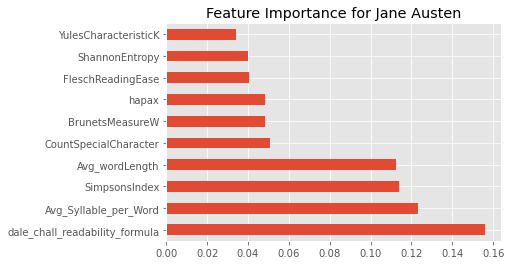

In [48]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Feature Importance for Jane Austen")
plt.show()

Text(0.5, 1.0, 'DARF vs Syllable per Word')

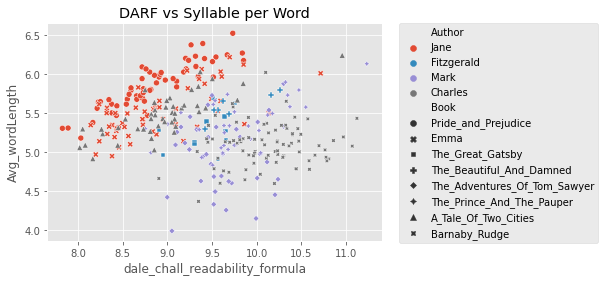

In [49]:
sns.scatterplot(data=allbookf, x="dale_chall_readability_formula", y="Avg_wordLength",
                hue="Author",style='Book')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("DARF vs Syllable per Word")

Text(0.5, 1.0, 'DARF Boxplot')

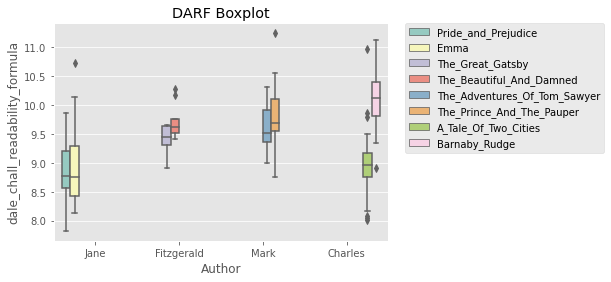

In [45]:
sns.boxplot(x="Author", y="dale_chall_readability_formula", hue="Book",
                 data=allbookf, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("DARF Boxplot")

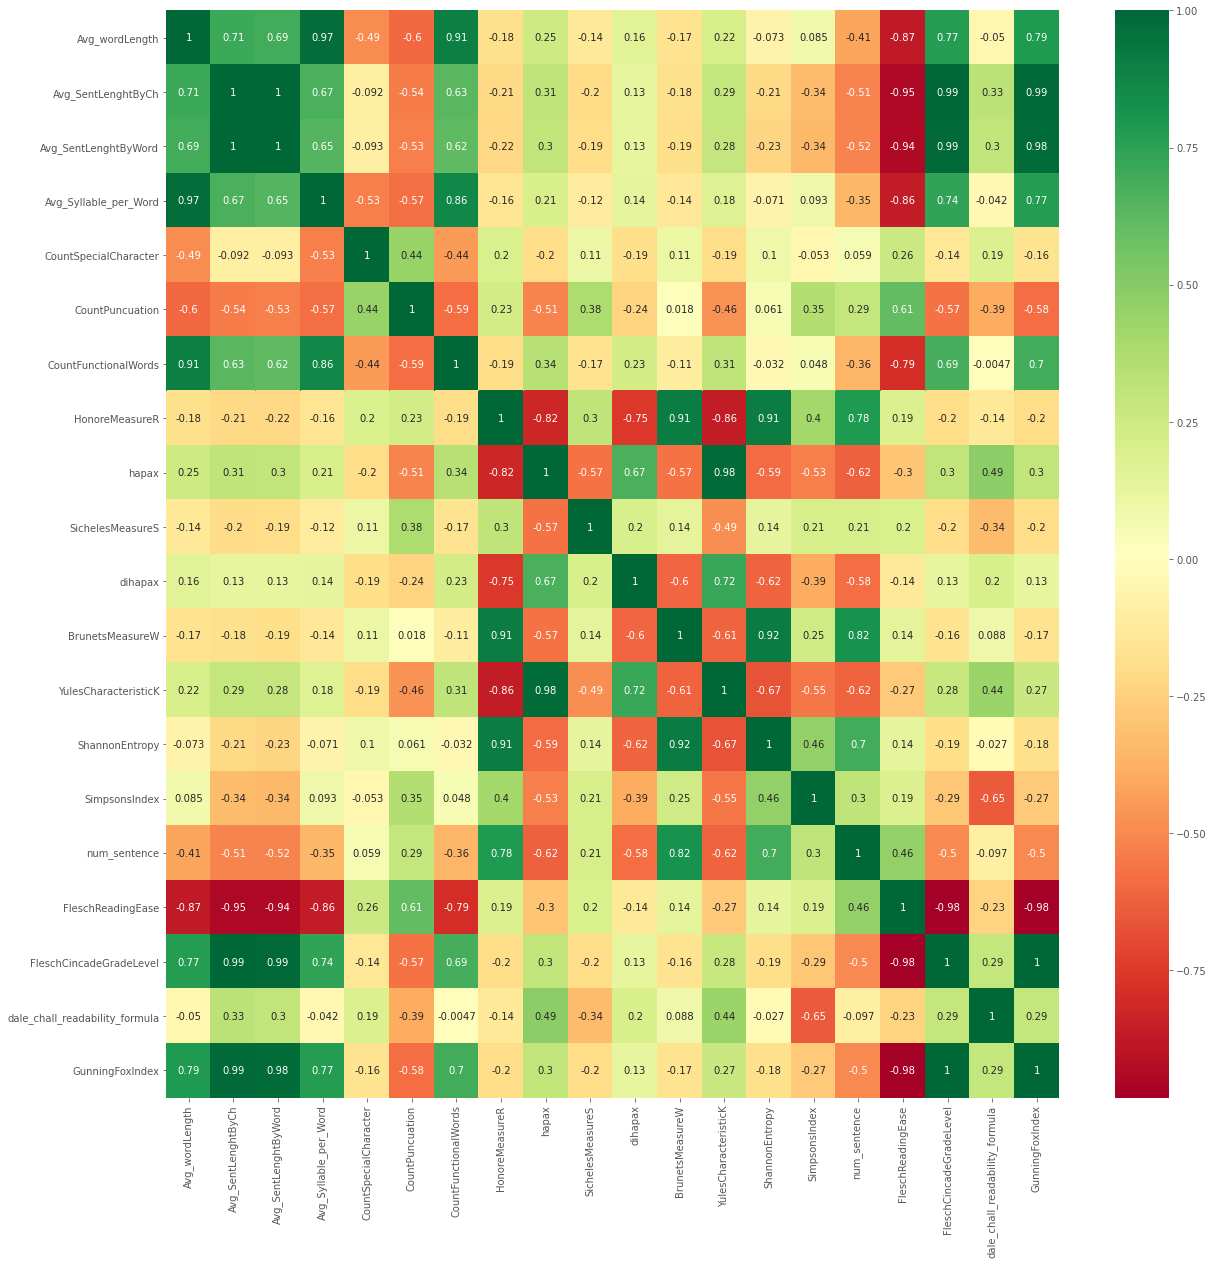

In [200]:
corrmat = allbookf.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(allbookf[top_corr_features].corr(),annot=True,cmap="RdYlGn")